## feature 추출
: 1 **score** → n **resized staves →** n **feature →** 다 이어서 1 **csv file**
- n **resized stave images, csv file은** `data/processed-feature/{title}/` **에 저장됨.**

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
import cv2
import csv
import json
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
from datetime import datetime

constant

In [2]:
DATA_PATH=f"../data"
MODEL_PATH=f"../model"
IMAGE_PATH=f"../images/"

DATA_FEATURE_PATH=f"{DATA_PATH}/processed-feature"
DATA_RAW_PATH=f"{DATA_PATH}/raw"
DATA_TEST_PATH=f"{DATA_PATH}/test"

OSMD="osmd-dataset-v1.0.0"

STAVE = "stave"
PAD_STAVE = "pad-stave"
FEATURE = "feature"
LABELED_FEATURE = "labeled-feature"
CURSOR="cursor"

OMR="omr-seq2seq"

STAVE_HEIGHT = 90
STAVE_WIDTH = 925

# -- width:20 중에 | 좌우 8pad * 2 -> 4px
NOTE_PAD = 8 # -> 4

pitch

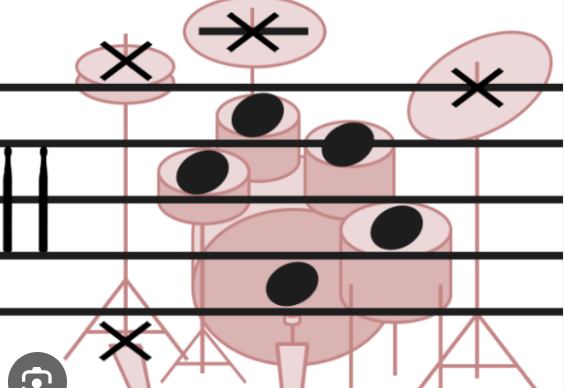

In [3]:
REST_QUARTER="REST_QUARTER"
REST_EIGHTH="REST_EIGHTH"  
REST_HALF="REST_HALF"
REST_WHOLE="REST_WHOLE"

PITCH_NOTES = ['D4', 'F4', 'A4', 'C5', 'D5', 'E5', 'F5', 'G5', 'A5', REST_QUARTER, REST_EIGHTH, REST_HALF, REST_WHOLE]
PTICH_HEIGHT = len(PITCH_NOTES)

# -- 각 0 ~ 16 로 매핑 -> 실제 pitch는 -4 해주면 됨.
# {0: 'A3', 1: 'B3', 2: 'C4', 3: 'D4', 4: 'E4', 5: 'F4', 6: 'G4', 7: 'A4', 8: 'B4', 9: 'C5', 10: 'D5', 11: 'E5', 12: 'F5', 13: 'G5', 14: 'A5', 15: 'B5', 16: 'C6'}
CODE2PITCH_NOTE = {index: note for index, note in enumerate(PITCH_NOTES)}
# {'A3': 0, 'B3': 1, 'C4': 2, 'D4': 3, 'E4': 4, 'F4': 5, 'G4': 6, 'A4': 7, 'B4': 8, 'C5': 9, 'D5': 10, 'E5': 11, 'F5': 12, 'G5': 13, 'A5': 14, 'B5': 15, 'C6': 16}
PITCH_NOTE2CODE = {note: index for index, note in enumerate(PITCH_NOTES)}

가능한 라벨링 조합 생성 -> decimal -> onehotencoder category 생성을 위해
```
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1] -> decimal -> onehotencoder
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
```

In [4]:
import itertools

rest_indices = [9, 10, 11, 12]
def contains_specific_indices_tuple(tpl, indices):
    """
    Check if specific indices are present in the tuple.

    Args:
    - tpl (tuple): Input tuple.
    - indices (list): List of indices to check.

    Returns:
    - contains (bool): True if any of the indices are present in the tuple, False otherwise.
    """
    for indice in indices:
        if indice in tpl:
            return True
    return False

def generate_multilabel_vectors(max_notes, max_combinations):
    """
    Generate multilabel vectors for pitch notes combinations with maximum 3 ones.
    
    Args:
    - max_notes (int): Maximum number of notes.
    - max_combinations (int): Maximum number of combinations.
    
    Returns:
    - multilabel vectors (list): List of one-hot vectors.
    """
    multilabel_vectors = []
    multilabel_vectors.append([0]*PTICH_HEIGHT)
    for num_notes in range(1, min(4, max_notes + 1)):  # 최대 3개의 1만 가진 조합 생성
        combinations = itertools.combinations(range(max_notes), num_notes)
        for combination in combinations:
            if len(multilabel_vectors) >= max_combinations:
                return multilabel_vectors
            one_hot = [0] * max_notes

            # rest는 최대 1개의 조합으로만
            # rest가 9,10,11,12 번째에 위치해 있을 거라서
            # 9,10,11,12라는 숫자가 1번째 인덱스 이상에 존재하면 continue
            if len(combination) > 1 and contains_specific_indices_tuple(combination, rest_indices):
                continue
            for index in combination:
                one_hot[index] = 1
            multilabel_vectors.append(one_hot)
    return multilabel_vectors

# Example usage:
max_notes = PTICH_HEIGHT
max_combinations = 8191  # Maximum number of combinations
multilabel_vectors = generate_multilabel_vectors(max_notes, max_combinations)
for vector in multilabel_vectors:
    print(vector)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
def binary_to_string(binary_list):
    # 이진수를 문자열로 변환하는 함수 정의
    binary_list = list(map(int, binary_list))  # 정수로 변환
    return "".join(map(str, binary_list))

def binary_to_decimal(binary_string):
    # 이진수를 10진수로 변환하는 함수 정의
    return int(binary_string, 2)

def decimal_to_binary(decimal_number):
    # 10진수를 이진수로 변환하는 함수 정의
    binary_string = bin(decimal_number)[2:]
    # 2진수를 라벨 개수 자리로 맞추기 위해 앞에 0을 채움
    binary_string = (
        "0" * (len(CODE2PITCH_NOTE) - len(binary_string)) + binary_string
    )
    return [*map(int, binary_string)]

def one_hot_label_to_number(labels: np.array):
    # 각 리스트를 이진수로 변환한 뒤 10진수로 변환하여 저장
    return np.apply_along_axis(
        lambda x: binary_to_decimal(binary_to_string(x)),
        axis=1,
        arr=labels,
    )

def number_to_one_hot_label(labels: np.array):
    # 10진수를 다시 이진수로 변환하여 배열에 저장
    return np.array([decimal_to_binary(decimal) for decimal in labels])

onehot encoder: 카테고리 생성

```
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1] -> decimal -> onehotencoder
```

In [6]:
from sklearn.preprocessing import OneHotEncoder

decimal_vector = one_hot_label_to_number(multilabel_vectors).reshape(-1, 1)
print("-- decimal_vector: ", decimal_vector)

# -------------------------------------------------
# OneHotEncoder 객체 생성
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') # sparse를 False로 설정하면 넘파이 배열을 반환
onehot_encoder = onehot_encoder.fit(decimal_vector)
print("-- category: ", len(onehot_encoder.categories_))
print(onehot_encoder.categories_)

onehot_label_category= onehot_encoder.transform(decimal_vector)
print("-- onehot_label_category: ", onehot_label_category.shape)
print(onehot_label_category)

-- decimal_vector:  [[   0]
 [4096]
 [2048]
 [1024]
 [ 512]
 [ 256]
 [ 128]
 [  64]
 [  32]
 [  16]
 [   8]
 [   4]
 [   2]
 [   1]
 [6144]
 [5120]
 [4608]
 [4352]
 [4224]
 [4160]
 [4128]
 [4112]
 [3072]
 [2560]
 [2304]
 [2176]
 [2112]
 [2080]
 [2064]
 [1536]
 [1280]
 [1152]
 [1088]
 [1056]
 [1040]
 [ 768]
 [ 640]
 [ 576]
 [ 544]
 [ 528]
 [ 384]
 [ 320]
 [ 288]
 [ 272]
 [ 192]
 [ 160]
 [ 144]
 [  96]
 [  80]
 [  48]
 [7168]
 [6656]
 [6400]
 [6272]
 [6208]
 [6176]
 [6160]
 [5632]
 [5376]
 [5248]
 [5184]
 [5152]
 [5136]
 [4864]
 [4736]
 [4672]
 [4640]
 [4624]
 [4480]
 [4416]
 [4384]
 [4368]
 [4288]
 [4256]
 [4240]
 [4192]
 [4176]
 [4144]
 [3584]
 [3328]
 [3200]
 [3136]
 [3104]
 [3088]
 [2816]
 [2688]
 [2624]
 [2592]
 [2576]
 [2432]
 [2368]
 [2336]
 [2320]
 [2240]
 [2208]
 [2192]
 [2144]
 [2128]
 [2096]
 [1792]
 [1664]
 [1600]
 [1568]
 [1552]
 [1408]
 [1344]
 [1312]
 [1296]
 [1216]
 [1184]
 [1168]
 [1120]
 [1104]
 [1072]
 [ 896]
 [ 832]
 [ 800]
 [ 784]
 [ 704]
 [ 672]
 [ 656]
 [ 608]
 [ 5

/home/jaeserrr/anaconda3/envs/drum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# n_rows = STAVE_WIDTH
# n_rows = 185
n_rows = 37
n_columns = STAVE_HEIGHT
n_classes = onehot_label_category.shape[1]

In [8]:
def get_datetime():
    return datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
def get_title(score_path):
    return os.path.basename(os.path.dirname(score_path))

In [9]:
def get_all_files(parent_folder_path, exp):
    all_file_list = glob.glob(f"{parent_folder_path}/*")
    file_list = [file for file in all_file_list if file.endswith(f".{exp}")]
    return file_list

## 이미지 전처리

In [10]:
def transform_img2binaryImg(img):
    """
    param : rgb image
    return : binary image
    """
    img = cv2.imread(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # -- 설정 임곗값(retval), 결과 이미지(biImg)
    ret, biImg = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV) # -- 임곗값을 초과할 경우 0, 아닐 경우 maxval
    return biImg

In [11]:
def get_score_data(score_path):
    """
    score의 binary img, size 얻기
    return: binary img, height, width
    """
    biImg = transform_img2binaryImg(score_path)
    height, width = biImg.shape
    return biImg, height, width

In [12]:
def extract_segment_from_score(biImg):
    """
    score에서 각 segment 추출
    객체 정보를 함께 반환하는 레이블링 함수
    cnt : 객체 수 + 1 (배경 포함)
    labels : 객체에 번호가 지정된 레이블 맵
    stats : N x 5, N은 객체 수 + 1이며 각각의 행은 번호가 지정된 객체를 의미, 5열에는 x, y, width, height, area 순으로 정보가 담겨 있습니다. x,y 는 좌측 상단 좌표를 의미하며 area는 면적, 픽셀의 수를 의미합니다.
    centroids : N x 2, 2열에는 x,y 무게 중심 좌표가 입력되어 있습니다. 무게 중심 좌표는 픽셀의 x 좌표를 다 더해서 갯수로 나눈 값입니다. y좌표도 동일합니다.
    """
    cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(biImg)
    return cnt, labels, stats, centroids

In [13]:
def extract_stave_from_score(biImg, score_width, cnt, stats):
    """
    stave 추출
    """
    stave_list=[]
    # -- idx 0은 배경이라 제외
    for i in range(1, cnt):
        x, y, w, h, _ = stats[i]
        # -- stave 인식
        if w > score_width * 0.3: # -- stave width가 score width와 같지 않은 경우가 있을 수도 있음
            stave = biImg[y:y+h, x:x+w]
            stave_list.append(stave)

    return stave_list

In [14]:
def save_stave(title, stave_list, state):
    """
    save stave list
    """
    os.makedirs(f"{DATA_FEATURE_PATH}/{title}", exist_ok=True)
    for idx, stave in enumerate(stave_list):
        date_time = get_datetime()
        cv2.imwrite(f"{DATA_FEATURE_PATH}/{title}/{title}_{state}_{idx}_{date_time}.png", stave)
        print(state, idx, "--shape: ", stave.shape)

In [15]:
def transform_score2stave(score_path):
    """
    score로부터 stave image추출
    """

    biImg, _, width = get_score_data(score_path)

    cnt, _, stats, _ = extract_segment_from_score(biImg)

    stave_list = extract_stave_from_score(biImg, width, cnt, stats)

    return stave_list

# score로부터 stave image추출!!!!

In [16]:
score_path = f"{DATA_RAW_PATH}/{OSMD}/Rock-ver/Rock-ver.png" # -- stave를 추출할 악보
title = get_title(score_path)

stave_list = transform_score2stave(score_path)
save_stave(title, stave_list, STAVE)

stave 0 --shape:  (84, 925)
stave 1 --shape:  (88, 925)
stave 2 --shape:  (86, 925)
stave 3 --shape:  (86, 925)
stave 4 --shape:  (88, 925)
stave 5 --shape:  (88, 925)
stave 6 --shape:  (88, 925)
stave 7 --shape:  (86, 925)
stave 8 --shape:  (86, 925)
stave 9 --shape:  (86, 925)
stave 10 --shape:  (86, 925)
stave 11 --shape:  (86, 925)
stave 12 --shape:  (86, 925)
stave 13 --shape:  (86, 925)
stave 14 --shape:  (86, 925)
stave 15 --shape:  (86, 925)
stave 16 --shape:  (86, 925)
stave 17 --shape:  (86, 925)
stave 18 --shape:  (86, 925)
stave 19 --shape:  (87, 925)
stave 20 --shape:  (87, 925)
stave 21 --shape:  (86, 472)


-----------------------------------------------

In [17]:
def transform_stave2padStave(stave_list):
    pad_stave = []
    for stave in stave_list:
        pad_image = np.zeros((STAVE_HEIGHT, STAVE_WIDTH))

        # 새로운 이미지에 주어진 이미지 삽입
        pad_image[:stave.shape[0], :stave.shape[1]] = stave

        # 부족한 부분 0으로 채우기
        pad_image[stave.shape[0]:, :] = 0  # 높이 부족 부분
        pad_image[:, stave.shape[1]:] = 0  # 너비 부족 부분
        pad_stave.append(pad_image)
    return pad_stave

# Padding Stave Image

In [18]:
pad_stave_list = transform_stave2padStave(stave_list)
save_stave(title, pad_stave_list, PAD_STAVE)

pad-stave 0 --shape:  (90, 925)
pad-stave 1 --shape:  (90, 925)
pad-stave 2 --shape:  (90, 925)
pad-stave 3 --shape:  (90, 925)
pad-stave 4 --shape:  (90, 925)
pad-stave 5 --shape:  (90, 925)
pad-stave 6 --shape:  (90, 925)
pad-stave 7 --shape:  (90, 925)
pad-stave 8 --shape:  (90, 925)
pad-stave 9 --shape:  (90, 925)
pad-stave 10 --shape:  (90, 925)
pad-stave 11 --shape:  (90, 925)
pad-stave 12 --shape:  (90, 925)
pad-stave 13 --shape:  (90, 925)
pad-stave 14 --shape:  (90, 925)
pad-stave 15 --shape:  (90, 925)
pad-stave 16 --shape:  (90, 925)
pad-stave 17 --shape:  (90, 925)
pad-stave 18 --shape:  (90, 925)
pad-stave 19 --shape:  (90, 925)
pad-stave 20 --shape:  (90, 925)
pad-stave 21 --shape:  (90, 925)


---

In [19]:
def transform_staveImg2feature(img_list):
    """
    (선택)
    pad image file로부터 feature 추출
    단, padding 된 png만 (pad-stave 이름 붙은 것들만)
    """
    feature_list=[]
    for idx, img in enumerate(img_list):
        if PAD_STAVE in img:
            biImg = transform_img2binaryImg(img)
            feature_list.append(biImg)
            print(idx, "--shape: ", biImg.shape)
    return feature_list

In [20]:
def save_feature_csv(title, features, state):
    """
    state : LABELED_FEATURE | FEATURE 
    """
    date_time = get_datetime()
    save_path = f"{DATA_FEATURE_PATH}/{title}/{title}_{state}_{date_time}.csv"
    df = pd.DataFrame(features)
    df.to_csv(save_path, index=False, header=False)
    print("features shape: ", df.shape)

## csv 파일로 저장

In [21]:
# -- 1. image file로부터 feature 저장하려면 아래 코드
# img_list = get_all_files(f"{DATA_FEATURE_PATH}/{title}", "png")
# feature_list = transform_staveImg2feature(img_list)
# -- 2. 위 feature 그대로 쓰려면 아래 코드
feature_list = pad_stave_list

# 데이터 이어붙이기
merged_data = np.concatenate(feature_list, axis=1)

# 전치
transposed_data = np.transpose(merged_data)

save_feature_csv(title, transposed_data, FEATURE)

features shape:  (20350, 90)


---

## XML 라벨링

In [22]:
def load_xml_data(file_path: str):
    """
    xml data 불러오기
    """
    try:
        tree = ET.parse(file_path)  # XML 파일을 파싱
        root = tree.getroot()
        return root
    except ET.ParseError as e:
        print(f"XML 파일을 파싱하는 동안 오류가 발생했습니다: {e}")
        return None

In [23]:
def extract_pitch(xml_file):
    """
    1. multiple pitch 추출
    <chord/> <-  얘 있으면 동시에 친 거임
    <unpitched>
        <display-step>A</display-step>
        <display-octave>5</display-octave>
    </unpitched>

    2. !!!!!!!!!!!!!예외!!!!!!!!!!!!!
    - grace note 제외

    3. 쉼표 추출
    <note>
        <rest/>
        <duration>48</duration>
        <type>quarter</type>
    </note>

    output : [['G5'], ['G5'], ['G5'], ['C5'], ['C5'], ['F4', 'A5'], ...]
    """
    def extract_step_octave(pitch_element):
        """
        step, octave 추출
        <unpitched>
            <step>C</step>
            <octave>5</octave>
        </unpitched>
        """
        step = pitch_element.find('display-step').text
        octave = pitch_element.find('display-octave').text
        return step, octave
    
    # XML 파일 파싱
    root = load_xml_data(xml_file)
    
    pitch_list = []
    chord_list = []

    # 모든 <note> 엘리먼트를 찾습니다.
    for note in root.iter('note'):
        # <grace> 엘리먼트를 가진 <note> 엘리먼트인지 확인
        is_grace = note.find('grace') is not None
        if is_grace:
            print("grace!")
            continue

        # <rest> 엘리먼트를 가진 <note> 엘리먼트인지 확인
        # REST_QUARTER="REST_QUARTER"
        # REST_EIGHTH="REST_EIGHTH"  
        # REST_HALF="REST_HALF"
        # REST_WHOLE="REST_WHOLE"
        is_rest = note.find('rest') is not None
        if is_rest:
            rest_element = note.find('type').text
            if rest_element == 'quarter':
                pitch_list.append([REST_QUARTER])
            elif rest_element == 'eighth':
                pitch_list.append([REST_EIGHTH])
            elif rest_element == 'half':
                pitch_list.append([REST_HALF])
            elif rest_element == 'whole':
                pitch_list.append([REST_WHOLE])
            continue

        pitch_elements = note.findall('./unpitched')
        # <chord> 엘리먼트를 가진 <note> 엘리먼트인지 확인
        is_chord = note.find('chord') is not None
        # 만약 <chord> 엘리먼트를 가진 <note> 엘리먼트라면, 계속 추가
        if is_chord:
            for pitch_element in pitch_elements:
                step, octave = extract_step_octave(pitch_element)
                chord_list.append(step + octave)
        else:
            for pitch_element in pitch_elements:
                step, octave = extract_step_octave(pitch_element)
                chord_list = [] # -- 초기화
                chord_list.append(step + octave)
                pitch_list.append(chord_list)
    
    return pitch_list

In [24]:
# XML 파일 경로
xml_file_path = f'{DATA_RAW_PATH}/{OSMD}/{title}/Rock-ver.xml'
pitch_list = extract_pitch(xml_file_path)

# 결과를 출력합니다.
for i, pitches in enumerate(pitch_list, 1):
    print(f"Note {i}: {' '.join(pitches)}")

grace!
grace!
grace!
grace!
Note 1: G5
Note 2: G5
Note 3: G5
Note 4: C5
Note 5: F4 A5
Note 6: C5 G5
Note 7: G5
Note 8: F4 G5
Note 9: F4 G5
Note 10: C5 G5
Note 11: G5
Note 12: F4 G5
Note 13: G5
Note 14: C5 G5
Note 15: G5
Note 16: F4 G5
Note 17: F4 G5
Note 18: C5 G5
Note 19: G5
Note 20: F4 G5
Note 21: G5
Note 22: C5 G5
Note 23: G5
Note 24: F4 G5
Note 25: F4 G5
Note 26: C5 G5
Note 27: F4 A5
Note 28: REST_EIGHTH
Note 29: F4
Note 30: C5 G5
Note 31: G5
Note 32: F4 G5
Note 33: F4 G5
Note 34: C5 A5
Note 35: F4 A5
Note 36: G5
Note 37: C5 G5
Note 38: G5
Note 39: F4 G5
Note 40: F4 G5
Note 41: C5 G5
Note 42: G5
Note 43: F4 G5
Note 44: G5
Note 45: C5 G5
Note 46: G5
Note 47: F4 G5
Note 48: F4 G5
Note 49: C5 G5
Note 50: G5
Note 51: F4 G5
Note 52: G5
Note 53: C5 G5
Note 54: G5
Note 55: F4 G5
Note 56: F4 G5
Note 57: C5 G5
Note 58: F4 A5
Note 59: REST_QUARTER
Note 60: REST_QUARTER
Note 61: REST_EIGHTH
Note 62: F4
Note 63: C5
Note 64: F4 A5
Note 65: C5 G5
Note 66: G5
Note 67: F4 G5
Note 68: F4 G5
Note 69

## cursor 정보를 이용해 라벨링

### cursor 확인

In [25]:
def get_cursor_data(point):
    # cursor 정보는 1024 기준이라서 x2
    top = int(point["top"])
    left = int(point["left"])
    height = int(point["height"])
    width = int(point["width"])

    return top, left, height, width

In [26]:
def draw_cursor_on_score(image_path, json_path):
    """
    OSMD로 추출한 cursor 위치값을 score에 그려보기
    """
    # 이미지 읽어오기
    image = cv2.imread(image_path)

    # JSON 파일 읽어오기
    with open(json_path, "r") as json_file:
        data = json.load(json_file)

    # 빨간색 네모 그리기
    for cursor in data["cursorList"]:
        for point in cursor:
            top, left, height, width = get_cursor_data(point)
            cv2.rectangle(image, (left+NOTE_PAD, top), (left + width-NOTE_PAD, top + height), (0, 0, 255), 2)
    date_time = get_datetime()
    cv2.imwrite(f"{DATA_FEATURE_PATH}/{title}/{title}-{CURSOR}-{date_time}.png", image)

In [27]:
json_path=f"{DATA_RAW_PATH}/{OSMD}/{title}/{title}.json"
draw_cursor_on_score(score_path, json_path)

### 라벨링

In [28]:
def load_feature_from_csv(csv_file_path):
    df = pd.read_csv(csv_file_path)
    print("csv shape: ", df.shape)
    return df

In [29]:
csv_file_path=get_all_files(f"{DATA_FEATURE_PATH}/{title}", "csv")

# label_feature 없애기
filtered_list = [s for s in csv_file_path if LABELED_FEATURE not in s]
feature_df = load_feature_from_csv(filtered_list[-1])

csv shape:  (20349, 90)


라벨 label_df [0,0,0,0,0,32,32,0,0,0,0,128,128,...] 생성

In [30]:
"""
1. 먼저 가로로 label df 생성 후
2. feature df + label df.T -> new csv
"""
with open(json_path, "r") as json_file:
    data = json.load(json_file)

# shape: 1 x feature concat width
label_df = pd.DataFrame(0, index=range(1), columns=range(feature_df.shape[0]))
score_leftpad = data["measureList"][0][0]["left"] # -- stave는 score의 양옆 padding을 자르게 되니, 실제 cursor size와 달라짐. -> 맨 처음 마디의 x 만큼 sliding

cursor_list=0
# cursorList-2d: row 마디 x col 노트 
for i, cursor in enumerate(data["cursorList"]):
    print("len: ", len(cursor))

    for j, point in enumerate(cursor):
        print("-- row: ", i,", col: ",j," --")

        top, left, height, width = get_cursor_data(point)
        left += i * STAVE_WIDTH - score_leftpad
        print("position : ", left)

        # -- 노트 인식된 곳에, xml에서 뽑아온 걸 매핑
        # ['D4', 'A5'] -> [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        pitch_code = [0]*PTICH_HEIGHT
        for pitch in pitch_list[cursor_list]:
            pitch_idx=PITCH_NOTE2CODE[pitch]
            pitch_code[pitch_idx]=1

        # binary list -> decimal num
        # [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] -> [32]
        pitch_comb_number = [binary_to_decimal(binary_to_string(pitch_code))]
        print("pitch num: ", pitch_comb_number)
        
        right_idx = min(left + width, label_df.shape[1]) # -- shape을 넘길 수 있어서
        tmp_width = right_idx - left - 2*NOTE_PAD
        pitch_code_df = [pitch_comb_number.copy() for _ in range(tmp_width)]
        transpose_data = np.transpose(pitch_code_df)
        
        # label_df.loc[:, left+7: left+width-1-9 ] = transpose_data
        label_df.loc[:, left+NOTE_PAD: left+width-1-NOTE_PAD ] = transpose_data
        cursor_list+=1
        # print(label_df.loc[:, left: left + tmp_width-1])
    print("----------------------------")
    
print("pitch_list len: ", len(pitch_list), "cursor len:", cursor_list)

label_df = np.transpose(label_df)

# feature_df = pd.DataFrame(feature_df)
# label_df = pd.DataFrame(label_df)

merged_df = pd.concat([feature_df, label_df], axis=1)
save_feature_csv(title, merged_df, LABELED_FEATURE)

len:  27
-- row:  0 , col:  0  --
position :  67
pitch num:  [32]
-- row:  0 , col:  1  --
position :  103
pitch num:  [32]
-- row:  0 , col:  2  --
position :  144
pitch num:  [32]
-- row:  0 , col:  3  --
position :  207
pitch num:  [512]
-- row:  0 , col:  4  --
position :  273
pitch num:  [2064]
-- row:  0 , col:  5  --
position :  307
pitch num:  [544]
-- row:  0 , col:  6  --
position :  333
pitch num:  [32]
-- row:  0 , col:  7  --
position :  360
pitch num:  [2080]
-- row:  0 , col:  8  --
position :  386
pitch num:  [2080]
-- row:  0 , col:  9  --
position :  412
pitch num:  [544]
-- row:  0 , col:  10  --
position :  438
pitch num:  [32]
-- row:  0 , col:  11  --
position :  479
pitch num:  [2080]
-- row:  0 , col:  12  --
position :  506
pitch num:  [32]
-- row:  0 , col:  13  --
position :  533
pitch num:  [544]
-- row:  0 , col:  14  --
position :  559
pitch num:  [32]
-- row:  0 , col:  15  --
position :  586
pitch num:  [2080]
-- row:  0 , col:  16  --
position :  613
pi

라벨 label_df을 one-hot-vector로 바꾸기
```
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
```

In [31]:
onehot_label_df = onehot_encoder.transform(label_df)
# onehot_label_df = onehot_label_df.toarray()

print(onehot_label_df)
save_feature_csv(title, onehot_label_df, LABELED_FEATURE) # 확인용

label_df = onehot_label_df

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
features shape:  (20349, 134)


In [32]:
def draw_label_on_cursor(image_path, json_path):
    """
    OSMD로 추출한 label을 cursor에 그려보기
    """
    # 이미지 읽어오기
    image = cv2.imread(image_path)

    # JSON 파일 읽어오기
    with open(json_path, "r") as json_file:
        data = json.load(json_file)

    cursor_list=0
    # cursorList-2d: row 마디 x col 노트 
    for i, cursor in enumerate(data["cursorList"]):
        for j, point in enumerate(cursor):
            top, left, height, width = get_cursor_data(point)

            # -- 노트 인식된 곳에, xml에서 뽑아온 걸 매핑
            for idx, pitch in enumerate(pitch_list[cursor_list]):
                cv2.putText(image, pitch, (left+NOTE_PAD, top+NOTE_PAD+idx*24), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1, cv2.LINE_AA)
            
            cursor_list+=1

    date_time = get_datetime()
    cv2.imwrite(f"{DATA_FEATURE_PATH}/{title}/{title}-label-{date_time}.png", image)

In [33]:
draw_label_on_cursor(score_path, json_path)

# Train

In [34]:
def split_x_data(data, chunk_size):
    num_samples, num_features = data.shape
    num_chunks = num_samples // chunk_size

    # 나머지 부분을 제외한 데이터만 사용
    data = data[: num_chunks * chunk_size, :]

    # reshape을 통해 3D 배열로 변환
    return data.reshape((num_chunks, chunk_size, num_features, 1))

def split_data(data, chunk_size):
    num_samples, num_features = data.shape
    num_chunks = num_samples // chunk_size

    # 나머지 부분을 제외한 데이터만 사용
    data = data[: num_chunks * chunk_size, :]

    # reshape을 통해 3D 배열로 변환
    return data.reshape((num_chunks, chunk_size, num_features))
    # 데이터 분할을 위한 함수 정의

In [35]:
from sklearn.model_selection import train_test_split


X = split_x_data(feature_df.to_numpy(), n_rows)
y = split_data(label_df, n_rows)

# -- split train, val, test
x_train_temp, x_test, y_train_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
# del X
# del y

x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    x_train_temp,
    y_train_temp,
    test_size=0.2,
    random_state=42,
)
del x_train_temp
del y_train_temp

x_train = x_train_final
x_val = x_val_final
x_test = x_test
y_train = y_train_final
y_val = y_val_final
y_test = y_test

print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_val : ", x_val.shape)
print("y_val : ", y_val.shape)
print("x_test : ", x_test.shape)
print("y_test : ", y_test.shape)


x_train :  (351, 37, 90, 1)
y_train :  (351, 37, 134)
x_val :  (88, 37, 90, 1)
y_val :  (88, 37, 134)
x_test :  (110, 37, 90, 1)
y_test :  (110, 37, 134)


In [36]:
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Input, Bidirectional, Conv2D, MaxPooling2D, Reshape, TimeDistributed
from tensorflow.keras.optimizers import RMSprop

opt_learning_rate= 0.01

img_height=n_rows
img_width=n_columns

input_layer = Input(shape=(img_height, img_width))  # 이미지의 높이, 너비 및 채널

# Bidirectional LSTM layers
lstm1 = Bidirectional(LSTM(32, return_sequences=True))(input_layer)
lstm2 = Bidirectional(LSTM(32, return_sequences=True))(lstm1)
lstm3 = Bidirectional(LSTM(32, return_sequences=True))(lstm2)

# Flatten LSTM output
# output_layer = TimeDistributed(Dense(n_classes, activation="sigmoid"))(pool1)
output_layer = Dense(n_classes, activation="softmax")(lstm3)
model = Model(inputs=input_layer, outputs=output_layer)


opt = RMSprop(learning_rate=opt_learning_rate)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["binary_accuracy"]
)
model.summary()

2024-03-30 03:09:12.990812: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-30 03:09:13.049496: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-30 03:09:13.356094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 03:09:13.356217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 03:09:13.357177: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 37, 90)]          0         
                                                                 
 bidirectional (Bidirection  (None, 37, 64)            31488     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 37, 64)            24832     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 37, 64)            24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 37, 134)           8710      
                                                             

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size=32
training_epochs=40

# Implement model train logic
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, mode="auto"
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    epochs=training_epochs,
    callbacks=[early_stopping],
)

stopped_epoch = early_stopping.stopped_epoch
print("--! finish train : stopped_epoch >> ", stopped_epoch, " !--")

# Implement model evaluation logic
print("\n# Evaluate on test data")

results = model.evaluate(
    x_test, y_test, batch_size=batch_size
)
print("test loss:", results[0])
print("test accuracy:", results[1])

"""
-- 학습한 모델 저장하기
"""

# 현재 날짜와 시간 가져오기
date_time = get_datetime()
# 모델 저장
model_path = f"{MODEL_PATH}/pitch/{OMR}_pitch_multiclass_{date_time}.h5"
model.save(model_path)
print("--! save model: ", model_path)

y_pred = model.predict(x_test)
print(y_pred)

Epoch 1/40
11/11 [==============================] - 28s 485ms/step - loss: 1.3363 - binary_accuracy: 0.9970 - val_loss: 0.7022 - val_binary_accuracy: 0.9980
Epoch 2/40
11/11 [==============================] - 1s 92ms/step - loss: 0.6719 - binary_accuracy: 0.9981 - val_loss: 0.6528 - val_binary_accuracy: 0.9980
Epoch 3/40
11/11 [==============================] - 1s 96ms/step - loss: 0.6648 - binary_accuracy: 0.9980 - val_loss: 0.6419 - val_binary_accuracy: 0.9980
Epoch 4/40
11/11 [==============================] - 1s 111ms/step - loss: 0.5458 - binary_accuracy: 0.9982 - val_loss: 0.5154 - val_binary_accuracy: 0.9980
Epoch 5/40
11/11 [==============================] - 1s 94ms/step - loss: 0.4603 - binary_accuracy: 0.9983 - val_loss: 0.3874 - val_binary_accuracy: 0.9985
Epoch 6/40
11/11 [==============================] - 1s 127ms/step - loss: 0.3915 - binary_accuracy: 0.9985 - val_loss: 0.3590 - val_binary_accuracy: 0.9985
Epoch 7/40
11/11 [==============================] - 1s 118ms/step 

/home/jaeserrr/anaconda3/envs/drum/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 4s 28ms/step
[[[9.19196129e-01 2.17431504e-03 9.88326356e-05 ... 8.88629293e-05
   8.35035316e-05 1.02738908e-04]
  [9.99068081e-01 1.03551014e-04 3.52084868e-07 ... 3.07267584e-07
   2.76574411e-07 3.39416545e-07]
  [9.99768674e-01 2.40012196e-05 4.39559749e-08 ... 3.81488405e-08
   3.46194931e-08 4.51637980e-08]
  ...
  [9.16685760e-01 1.08365295e-03 3.36575476e-06 ... 1.95777898e-06
   3.11963754e-06 1.83589327e-06]
  [9.98108149e-01 2.40403577e-04 2.40864722e-07 ... 1.75411557e-07
   2.58214982e-07 2.01892817e-07]
  [9.96669829e-01 4.85253055e-04 1.34373238e-06 ... 1.19131016e-06
   1.46841558e-06 1.43298200e-06]]

 [[9.94390309e-01 8.40359309e-04 5.22634127e-06 ... 5.01608656e-06
   4.63342622e-06 5.21514903e-06]
  [9.99507189e-01 7.68935060e-05 1.39345133e-07 ... 1.29487063e-07
   1.11818323e-07 1.27359257e-07]
  [9.99801338e-01 2.92755958e-05 3.24062874e-08 ... 3.03338616e-08
   2.48164955e-08 3.08050900e-08]
  ...
  [9.99507308e-01 1.10322

In [38]:
from typing import List
import matplotlib.pyplot as plt

def show_label_dict_plot(label: dict[str, List[float]], start=0, end=None):
    """
    -- label 그래프
    {
        "HH": [1, 0, 0, ...],
        "ST": [0, 0, 0, ...],
        ...
    }
    """
    if end is None:  # end가 none이라면 y_true 끝까지
        end = len(label[list(label.keys())[0]])  # 첫 번째 value의 길이

    leng = len(PITCH_NOTE2CODE)
    for key, label_arr in label.items():
        data = np.array(label_arr)
        plt.subplot(leng, 1, PITCH_NOTE2CODE[key] + 1)
        plt.plot(data)
        plt.axis([start, end, 0, 1.0])
        plt.title(f"{key}")

    os.makedirs(IMAGE_PATH, exist_ok=True)  # 이미지 폴더 생성
    date_time=get_datetime()
    plt.savefig(f"{IMAGE_PATH}/pitch/pitch-predict-mat-{date_time}.png")
    plt.show()

In [39]:
def convert_to_sheet_music(prediction):
    sheet_music = []
    for note, probabilities in prediction.items():
        pitch_index = PITCH_NOTES.index(note)
        for i, prob in enumerate(probabilities):
            if prob == 1:
                sheet_music.append((pitch_index, i))
    return sheet_music

def plot_sheet_music(sheet_music):
    plt.figure(figsize=(10, 5))
    for pitch_index, time_index in sheet_music:
        plt.plot([time_index, time_index + 1], [pitch_index, pitch_index], color='black', linewidth=2)
    plt.yticks(range(len(PITCH_NOTES)), PITCH_NOTES)
    plt.xlabel('Time')
    plt.ylabel('Pitch')
    plt.title('Sheet Music Visualization')
    plt.grid(True)
    plt.xlim(0, max([time_index for _, time_index in sheet_music]) + 1)  # x 축 범위 설정
    os.makedirs(IMAGE_PATH, exist_ok=True)  # 이미지 폴더 생성
    date_time=get_datetime()
    plt.savefig(f"{IMAGE_PATH}/pitch/pitch-predict-sheet-{date_time}.png")
    plt.show()

-- ! load model:  ../model/pitch/omr-seq2seq_pitch_multiclass_2024-03-30_03-10-19.h5


1/1 [==============================] - 4s 4s/step
predict_data:  [[[9.91268992e-01 1.59719330e-03 1.02739386e-05 ... 8.63474816e-06
   7.91655293e-06 9.38558787e-06]
  [9.98765945e-01 2.65046052e-04 6.16784121e-07 ... 5.02434716e-07
   4.73968498e-07 4.94045480e-07]
  [9.99381065e-01 1.24534126e-04 1.90261545e-07 ... 1.68218079e-07
   1.48589763e-07 1.57256267e-07]
  ...
  [9.99273598e-01 6.87060456e-05 1.54562898e-07 ... 1.70394955e-07
   1.26646583e-07 1.40876125e-07]
  [9.97507811e-01 1.61899312e-04 6.95757308e-07 ... 8.19854620e-07
   6.10114967e-07 6.06491540e-07]
  [9.77192998e-01 7.86806631e-04 1.32321975e-05 ... 1.48048930e-05
   1.17902136e-05 9.70159454e-06]]

 [[9.91689563e-01 1.45275693e-03 9.44467683e-06 ... 7.66507856e-06
   6.99896918e-06 8.35463288e-06]
  [9.99075294e-01 1.89691360e-04 4.23763026e-07 ... 3.18662870e-07
   3.08839503e-07 3.22919220e-07]
  [9.99698639e-01 5.53077189e-05 7.79462326e-08 ... 6.13450979e-08
   5.67477159e-08 5.99121606e-08]
  ...
  [9.9989628

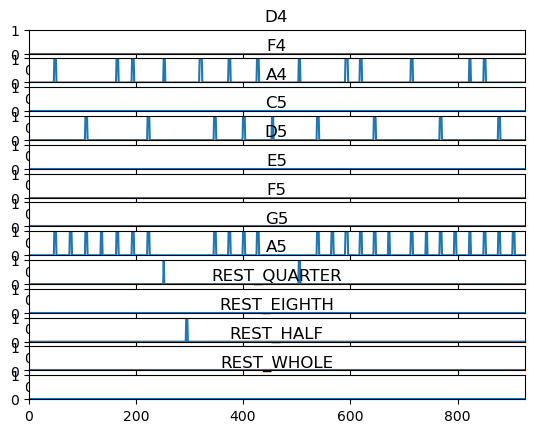

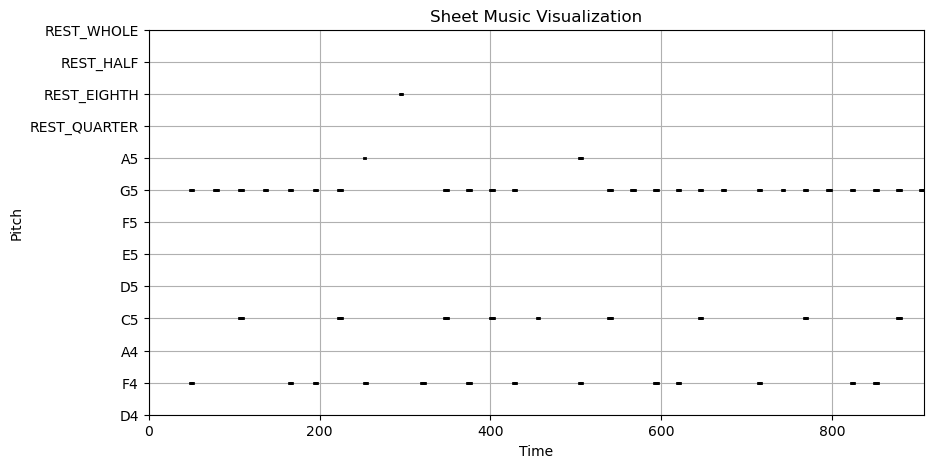

In [45]:
def transform_arr2dict(arr_data):
    print("shape:", arr_data.shape)

    result_dict = {}
    for code, drum in CODE2PITCH_NOTE.items():
        # print("--", code, drum)

        result_dict[drum] = [row[code] for row in arr_data]
        print(result_dict[drum])
    return result_dict

def load_models(model_file=None):
    """
    -- method_type과 feature type에 맞는 가장 최근 모델 불러오기
    """
    model_files = glob.glob(f"{MODEL_PATH}/pitch/*.h5")
    if model_files is None or len(model_files) == 0:
        print("-- ! No pre-trained model ! --")
        return

    model_files.sort(reverse=True)  # 최신 순으로 정렬
    load_model_file = model_files[0]  # 가장 최근 모델

    if model_file is not None:  # 불러오고자 하는 특정 모델 파일이 있다면
        load_model_file = model_file

    print("-- ! load model: ", load_model_file)
    model = tf.keras.models.load_model(load_model_file)
    return model

def predict_score(stave_path):
    # -- resized image -> binary image
    biImg = transform_img2binaryImg(stave_path)
    biImg = 255-biImg
    biImg = np.transpose(biImg)

    # save_feature_csv("asdf", biImg, FEATURE) # -- 잘 됐는지 눈으로 확인하기 위함..
    feature = split_x_data(biImg, n_rows)

    predict_data = model.predict(feature)
    print("predict_data: ", predict_data)
    print(predict_data.shape)

    predict_data = predict_data.reshape((-1, n_classes))
    print("reshape predict_data: ", predict_data.shape)
    print(predict_data)

    # 각 행에서 최댓값의 인덱스 찾기
    max_indices = np.argmax(predict_data, axis=1)
    # 결과 배열 초기화
    result = np.zeros_like(predict_data)
    # 최댓값 위치에 1 할당
    for i, idx in enumerate(max_indices):
        result[i, idx] = 1
    predict_data = result
    print("가장 높은 값만 1로: ", predict_data.shape)
    print(predict_data)
    
    # -- one hot [0,0,0,0,1,0,0,0,...] -> [32]
    inverse_onehot_predict_data=onehot_encoder.inverse_transform(predict_data)
    predict_data = np.array([item for sublist in inverse_onehot_predict_data for item in sublist])
    print("onehot 되돌리기: ", predict_data.shape)
    print(predict_data)

    # -- decimal -> binary
    binary_predict_data=number_to_one_hot_label(predict_data)
    print("binary 되돌리기: ", binary_predict_data.shape)
    print(binary_predict_data)

    predict_data = binary_predict_data

    # predict_data = predict_data.reshape((-1, n_classes))
    result_dict = transform_arr2dict(predict_data)
    show_label_dict_plot(result_dict)

    # 악보로 변환
    sheet_music = convert_to_sheet_music(result_dict)

    # 시각화
    plot_sheet_music(sheet_music)


model = load_models()
predict_score(f"{DATA_TEST_PATH}/Rock-ver_pad-stave_19_2024-03-26_08-35-59.png")
# predict_score(f"{DATA_TEST_PATH}/Rock-ver_pad-stave_9_2024-03-29_15-16-55.png")

In [ ]:
cv2.waitKey(0)
cv2.destroyAllWindows()